# <strong>Exponential Smoothing</strong>

Séries temporais podem ser entendidas como um conjunto de dados numéricos ordenados pelo tempo. Assim, torna-se possível acompanhar o comportamento de determinado fenômeno ao longo do tempo. 

Uma das maneiras de modelar uma série temporal é através do uso do método Exponential Smoothing, que recebe esse nome devido ao decaimento exponencial dos pesos para dados distantes (na escala de tempo) do valor mais recente. Assim, estudaremos desde a versão mais simples da representação da série até formas que levam em consideração tendência (trend) e sazonalidade (seasonal).

<strong>Importando os pacotes e gerando dados</strong>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import random

def mean_absolut_percentage_error(y_true,y_pred):
  return np.abs((y_true - y_pred) / y_true)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
random.seed(42)
simulated_values = random.sample(range(100000,1000000),30)
for i in range(len(simulated_values)):
  simulated_values[i] = simulated_values[i] + random.randint(-10000,10000)
simulated_date = pd.date_range(start = '1990-01-31',periods = 30,freq = 'M')

In [3]:
fake_data = pd.Series(data = simulated_values,index = simulated_date)
fake_data

1990-01-31    774233
1990-02-28    213962
1990-03-31    130944
1990-04-30    886881
1990-05-31    387504
1990-06-30    346999
1990-07-31    329284
1990-08-31    250164
1990-09-30    873395
1990-10-31    206578
1990-11-30    804664
1990-12-31    873701
1991-01-31    672887
1991-02-28    184510
1991-03-31    712215
1991-04-30    544866
1991-05-31    126495
1991-06-30    133007
1991-07-31    199516
1991-08-31    339040
1991-09-30    342629
1991-10-31    621326
1991-11-30    736316
1991-12-31    135395
1992-01-31    682598
1992-02-29    310899
1992-03-31    843382
1992-04-30    789542
1992-05-31    834998
1992-06-30    673262
Freq: M, dtype: int64

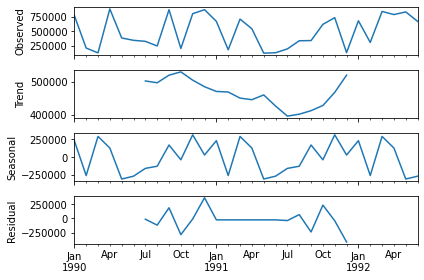

In [4]:
results = seasonal_decompose(fake_data)
results.plot()
plt.show()


##<strong>Forma 1: Simple Exponential Smoothing</strong>

A SES (Simple Exponential Smoothing) é um método que considera o último valor da série como o único representativo para descrever o comportamento do fenômeno. Assim, toda predição (forecast) é dada pelo último valor observado.

$$ypred_{T + h | T} = y_{T}$$

com $h$ = 1,2,3...

De forma geral, a expressão de forecasting (predição da série) para o primeiro dado não observado pode ser escrito como:

$$y_{T + 1|T} = \alpha * y_{T} + \alpha * (1 - \alpha) * y_{T-1} + \alpha * (1 - \alpha)^{2} * y_{T-2} + ...$$

onde $0 \leq \alpha \leq 1$ representa o parâmetro conhecido como level ou smoothing, que possibilita ponderar a importância dada aos dados. Valores pequenos de $\alpha$ indicam maior importância para dados no passado distante, enquanto que valores mais próximos de 1 indicam maior importância para o passado recente.

A definição acima permite-nos criar uma forma recursiva de obter predições para tempos futuros, dada por

$$ypred_{t + 1| t} = \alpha * y_{t} + (1 - \alpha) * ypred_{t | t - 1}$$

Para $1 \leq t \leq T$. Com isso, definindo $l_{0}$ como ponto de partida para esta forma recursiva, podemos escrever as seguintes relações:

$$ypred_{2|1} = \alpha * y_{1} + (1 - \alpha) * l_{0}$$
$$ypred_{3|2} = \alpha * y_{2} + (1 - \alpha) * ypred_{2|1}$$
$$ . $$
$$ . $$
$$ . $$
$$ypred_{T + 1| T} = \alpha * y_{T} + (1 - \alpha) * ypred_{T | T - 1}$$

Portanto, geramos uma expressão geral substituindo recursivamente as expressões acima definidas, obtendo:

$$ypred_{t + 1| t} = \sum_{j = 0}^{T -1} \alpha * (1 - \alpha)^{j} * y_{T-j}+ (1 - \alpha) ^ {T} * l_{0}$$

Toda essa dedução é conhecida (tradução livre) como forma média ponderada. Além desta, uma maneira equivalente e que facilita abordagens posteriores é a forma componente, no qual temos:

Forecast equation $$ypred_{t+h|t} = l_{t}$$

Smoothing equation
$$l_{t} = \alpha * y_{t} + (1 - \alpha) * l_{t-1}$$


Por fim, vale comentar que temos que encontrar quais os valores para $\alpha$ e $l_{0}$. Caso seja conhecido o comportamento padrão do fenômeno estudado, podem ser determinados manualmente ou então através de um problema de otimização, visando minimizar o a soma do erro quadrático.

In [4]:
# Apesar dos nomes train e test, lembramos que não trata-se de algo supervisionado. Os nomes atribuídos devem dar intuição de que teremos algum tipo de controle
# sobre os valores preditos, pois prediremos valores já conhecidos
y_train = fake_data[:-3]
y_test = fake_data[-3:]


In [5]:
fit1 = SimpleExpSmoothing(y_train).fit(smoothing_level = 0.6)
teste = ExponentialSmoothing(y_train).fit(smoothing_level = 0.6)
# Mesmo efeito
print(fit1.forecast(3))
teste.forecast(3)

1992-04-30    667806.986766
1992-05-31    667806.986766
1992-06-30    667806.986766
Freq: M, dtype: float64


1992-04-30    667806.986766
1992-05-31    667806.986766
1992-06-30    667806.986766
Freq: M, dtype: float64

### <strong>Forma 2: Adicionando trend</strong>

Uma variação da expressão abordada acima pode ser encontrada ao adicionar um termo que representa tendência. Anteriormente, vimos que no caso do SES as predições para dados não observados eram constantes e iguais ao último dado registrado. Com o uso desta técnica de trend, as predições agora possuem uma predição mais suave com o passar do tempo. Podemos escrever o método Exponential Smoothing com trend a partir de pequenas modificações na forma componente descrita anteriormente:

Forecast equation $$ypred_{t+h|t} = l_{t} + h*b_{t}$$

Level equation
$$l_{t} = \alpha * y_{t} + (1 - \alpha) * (l_{t-1} + b_{t-1})$$

Trend equation
$$b_{t} = \beta^{*}.(l_{t} - l_{t-1}) + (1 - \beta^{*}).b_{t-1}$$

Em que $0 \leq \beta \leq 1$ é o parâmetro de smoothing para o trend e $h$ define o tempo (passo) de projeção desejada. Note que para dados não observados, temos que o trend é constante. Esse fenômeno nem sempre possibilita predições precisas e para isto temos a possibilidade de inserir um parâmetro de damped trend, que penaliza o trend associado e assim pode permitir variações de crescimento e decrescimento (visto que um trend fixo mantém decrescimento ou crescimento constante com o passar do tempo). A inserção de damped trend na expressão promove a seguinte forma componente da série:

$$ypred_{t+h|t} = l_{t} + (\phi + \phi^{2} + ... + \phi^{h})*b_{t}$$
$$l_{t} = \alpha * y_{t} + (1 - \alpha) * (l_{t-1} + \phi.b_{t-1})$$
$$b_{t} = \beta^{*}.(l_{t} - l_{t-1}) + (1 - \beta^{*}).\phi.b_{t-1}$$

Em que $0 \leq \phi \leq 1$ e geralmente oscila entre 0.8 e 0.98. Além disso, para qualquer valor de $\phi$ entre 0 e 1 conseguimos garantir convergência de predição para $l_{T} + \dfrac{\phi.b_{T}}{1 - \phi}$.

In [6]:
fit2 = ExponentialSmoothing(y_train,trend = 'additive').fit(smoothing_level = 0.6,smoothing_slope = 0.4)
fit2_damped = ExponentialSmoothing(y_train,trend = 'additive', damped = True).fit(smoothing_level = 0.6,smoothing_slope = 0.4,damping_slope = 0.9)

print(fit2.forecast(3))
fit2_damped.forecast(3)

1992-04-30    745248.576179
1992-05-31    824577.606110
1992-06-30    903906.636042
Freq: M, dtype: float64


1992-04-30    733730.897332
1992-05-31    797987.723001
1992-06-30    855818.866104
Freq: M, dtype: float64

#### <strong>Forma 3: Adicionando sazonalidade</strong>

Por fim, a última forma leva em consideração a presença de sazonalidade, que é um fenômeno que se presente, indicam que há um padrão de comportamento nos dados dentro de um determinado período. Geralmente, os modelos implementados recebem um inteiro descrevendo o período dos dados dentrodo intervalo de um ano. Assim, um inteiro 3 como argumento indica por exemplo a presença de um padrão de comportamento trimestral.

A sazonalidade pode atuar de várias formas. Aqui explicaremos a maneira aditiva e multiplicativa, descrevendo a forma componente do método aditivo, que será também considerado no código abaixo apenas para fins de exemplo. A forma aditiva deve ser considerada quando a sazonalidade atua de maneira mais suave dentro do período de um ano, podendo ser considerada constante. No caso multiplicativo, a sazonalidade é escalonada proporcionalmente ao level da série e assim pode desempenhar melhor em problemas com extrema variação e irregularidades. A seguir há a forma componente da sazonalidade aditiva:

$$ypred_{t+h|t} = l_{t} + h*b_{t} + s_{t + h - m}.(k + 1)$$
$$l_{t} = \alpha * (y_{t} - s_{t-m}) + (1 - \alpha) * (l_{t-1} + b_{t-1})$$
$$b_{t} = \beta^{*}.(l_{t} - l_{t-1}) + (1 - \beta^{*}).b_{t-1}$$
$$s_{t} = \gamma.(y_{t} - l_{t-1} - b_{t-1}) + (1-\gamma).s_{t-m}$$

Em que $k$ é a parte inteira de $\dfrac{h-1}{m}$ e $m$ é o período de sazonalidade.

In [7]:
fit3 = ExponentialSmoothing(y_train,trend = 'additive',seasonal = 'additive',seasonal_periods=6).fit(smoothing_level = 0.5,smoothing_slope = 0.3,smoothing_seasonal = 0.3)
fit3.forecast(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


1992-04-30    785585.999838
1992-05-31    776332.992517
1992-06-30    612617.835611
Freq: M, dtype: float64

In [8]:
y_test

1992-04-30    789542
1992-05-31    834998
1992-06-30    673262
Freq: M, dtype: int64

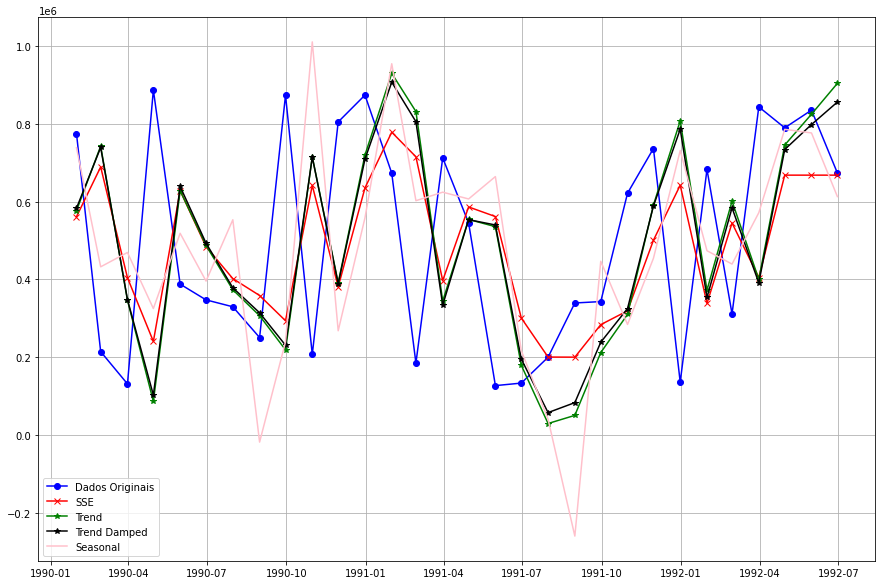

In [9]:
# Plotando gráficos
plt.figure(figsize = (15,10))
plt.plot(fake_data.index,fake_data,label = 'Dados Originais',color = 'blue',marker = 'o')
plt.plot(fake_data.index,np.concatenate((fit1.fittedvalues,fit1.forecast(3).values)),label = 'SSE',color = 'red',marker = 'x')
plt.plot(fake_data.index,np.concatenate((fit2.fittedvalues,fit2.forecast(3).values)),label = 'Trend',color = 'green',marker = '*')
plt.plot(fake_data.index,np.concatenate((fit2_damped.fittedvalues,fit2_damped.forecast(3).values)),label = 'Trend Damped',color = 'black',marker = '*')
plt.plot(fake_data.index,np.concatenate((fit3.fittedvalues,fit3.forecast(3).values)),label = 'Seasonal',color = 'pink')
plt.grid(True)
plt.legend(loc = 'best')


In [10]:
# Comparando erros
comp_model = pd.DataFrame(columns = ['Data', 'SSE','Com Trend','Trend e Damped', 'Seasonality'])
comp_model['Data'] = y_test.index
comp_model['SSE'] = mean_absolut_percentage_error(y_test.values,fit1.forecast(3).values)
comp_model['Com Trend'] = mean_absolut_percentage_error(y_test.values,fit2.forecast(3).values)
comp_model['Trend e Damped'] = mean_absolut_percentage_error(y_test.values,fit2_damped.forecast(3).values)
comp_model['Seasonality'] = mean_absolut_percentage_error(y_test.values,fit3.forecast(3).values)

comp_model

,Data,SSE,Com Trend,Trend e Damped,Seasonality
0,1992-04-30,0.154184,0.056100,0.070688,0.005010
1,1992-05-31,0.200229,0.012480,0.044324,0.070258
2,1992-06-30,0.008102,0.342578,0.271153,0.090075


In [11]:
modelos = ['SSE','Com Trend','Trend e Damped', 'Seasonality']
for modelo in modelos:
  print(f'O erro médio ao usar {modelo} como modelo foi {comp_model[modelo].mean()}')

O erro médio ao usar SSE como modelo foi 0.12083864749094192
O erro médio ao usar Com Trend como modelo foi 0.13705250802698146
O erro médio ao usar Trend e Damped como modelo foi 0.12872150745527322
O erro médio ao usar Seasonality como modelo foi 0.0551144318418326


##### <strong>Conclusão</strong>

Como vimos, são várias as possibilidades de uso e configuração de uma série temporal utilizando Exponential Smoothing. Para este notebook, não pensamos em otimizar os parâmetros, testar outros valores e nem demais configurações possíveis. Ao olhar o resultado gráfico e os erros obtidos, cabe ao cientista ou time de cientista julgar a qualidade do modelo a partir do fenômeno que se quer modelar. Com isso, as métricas e técnicas semelhantes às passadas aqui podem nortear uma tomada de decisão na escolha de melhores configurações e parâmetros para a série, tornando-a mais precisa e com maior capacidade de predizer acontecimentos reais. Por fim, vale comentar que existem outras técnicas de modelagem envolvendo séries temporais e que a escolhada técnica a ser utilizada também depende do problema e cabe ao cientista de dados conhecer e saber identificar a necessidade de modelos alternativos.

<strong>Referências</strong>
* https://otexts.com/fpp2/expsmooth.html
* https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc
* https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/